In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Dropout
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean

# Taiwan

## Methods

In [25]:
# Input in format:
# Fold: Amount of folds for k-folds
# datasetFeatures: The featuresof the data set in either 2d (customers, features) or 3d (customers, timesteps, features) format
# datasetLabels: The binary label of the dataset in shape (customers, 1)
# model: Pre-compiled keras model
# adj_mat: Adjecency matrix for graph based learning in shape (customers, customers)
# graph_based: Boolean set to true if model requires adjecency matrix
def plot_keras_roc(folds, datasetFeatures, datasetLabels, model, adj_mat=None, graph_based = False):
    k_fold = KFold(n_splits=folds, shuffle=True, random_state=42)

    #Local features
    all_tpr = []
    all_fpr = []
    all_auc = []
    train_accs = []
    test_accs = []
    f1_scores = []
    cf_matrices = []
    
    #Features to show plots
    fig, ax = plt.subplots(figsize=(6, 6))
    temp = []
    fold = list(range(1, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    #5-fold cv
    for train, test in k_fold.split(datasetFeatures, datasetLabels):
        
        
        #Graph based k-fold
        if graph_based == True:
            
            train_mask = np.zeros((8000,), dtype='bool')
            train_mask[train] = 1
            
            #Model fitting 
            history = model.fit([datasetFeatures, adj_mat], datasetLabels, sample_weight=train_mask, batch_size=8000, epochs=1000)
            
            #Predicitons on whole dataset
            predictions = model.predict([datasetFeatures, adj_mat], batch_size=8000).ravel()

            #False-positive and True-positive rate
            fpr, tpr, _ = metrics.roc_curve(datasetLabels, predictions)
            
            #Turn binary with threshold
            binaryPred = (predictions > 0.5)
            
            #Other metrics appended to return varaiables
            all_tpr.append(tpr)
            all_fpr.append(fpr)

            auc = metrics.auc(fpr, tpr)
            all_auc.append(auc)

            train_accs.append(metrics.accuracy_score(datasetLabels, binaryPred))
            f1_scores.append(metrics.f1_score(datasetLabels, binaryPred))
            cf_matrices.append(metrics.confusion_matrix(datasetLabels, binaryPred))

        #Same as above for models without graphs 
        else:
            history = model.fit(datasetFeatures[train], datasetLabels[train], validation_split=0.2, batch_size=10, epochs=20)

            trainPred = model.predict(datasetFeatures[train]).ravel()
            testPred = model.predict(datasetFeatures[test]).ravel()


            fpr, tpr, _ = metrics.roc_curve(datasetLabels[test], testPred)

            trainPred = (trainPred > 0.5)
            testPred = (testPred > 0.5)

            all_tpr.append(tpr)
            all_fpr.append(fpr)

            auc = metrics.auc(fpr, tpr)
            all_auc.append(auc)

            train_accs.append(metrics.accuracy_score(datasetLabels[train], trainPred))
            test_accs.append(metrics.accuracy_score(datasetLabels[test], testPred))
            f1_scores.append(metrics.f1_score(datasetLabels[test], testPred))
            cf_matrices.append(metrics.confusion_matrix(datasetLabels[test], testPred))



    #Code for plotting ROC-curve
    ax.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')

    for curr_tpr, curr_fpr, curr_auc, curr_fold in zip(all_tpr, all_fpr, all_auc, fold):
        ax.plot(curr_fpr, curr_tpr, label=f'ROC fold {curr_fold} (AUC = {curr_auc:.2f})', alpha=0.3)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0    
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1
    std_tpr = np.std(tprs, axis=0)

    mean_auc = np.mean(all_auc)
    std_auc = np.std(all_auc)

    ax.plot(mean_fpr,
           mean_tpr,
           color='b',
           label= f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
           lw=2,
           alpha= 0.8)

    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr + std_tpr, 0)

    ax.fill_between(mean_fpr,
                   tprs_lower,
                   tprs_upper,
                   color='grey',
                   alpha=0.2,
                   label='$\pm$ 1 std dev.')

    ax.set(xlim=[-0.05, 1.05],
          ylim=[-0.05, 1.05],
          xlabel='False Positive Rate',
          ylabel='True Positive Rate',
          title='ROC Curve')




    ax.legend(loc='lower right')

    plt.show()
    
    return train_accs, test_accs, f1_scores, cf_matrices

## Data

In [5]:
#TS data
taiwanTSData = pd.read_csv('finalTSTaiwan.csv', index_col=[0])

#Labels
taiwanLabels = taiwanTSData.Default
taiwanFeatures = taiwanTSData.drop('Default', axis=1)

Dataset contains a 50-50 split in labels, with the first 4000 in the dataset with a label of 1, and the next half label of 0

In [6]:
taiwanFeatures.head()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,1,2,2,0,0,2,65802,67369,65701,66782,36137,36894,3200,0,3000,3000,1500,0
3,0,0,2,2,2,2,15376,18010,17428,18338,17905,19104,3200,0,1500,0,1650,0
4,-1,-1,-1,-1,-1,-1,316,316,316,0,632,316,316,316,0,632,316,0


In [8]:
taiwanLabels.head()

0    1
1    1
2    1
3    1
4    1
Name: Default, dtype: int64

## LSTM

In [11]:
#Scale data
scaler = StandardScaler()
scaledTaiwanFeatures = scaler.fit_transform(taiwanFeatures)

In [12]:
#Reshaping data into 3d matrix
dim = len(taiwanFeatures.index.get_level_values(0).unique())
taiwanMutivariateData = scaledTaiwanFeatures.reshape((dim, 6, 3))

In [13]:
#(Customers, time steps, features)
taiwanMutivariateData.shape

(8000, 6, 3)

In [26]:
#Model defenition
input_ = Input(shape=(6, 3))
lstm1_ = LSTM(100, activation='relu')(input_)
output_ = Dense(1, activation='sigmoid')(lstm1_)

model = Model(inputs=input_, outputs=output_)

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-4), metrics = ['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               41600     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
512/512 [==============================] - 10s 11ms/step - loss: 0.6528 - accuracy: 0.6092 - val_loss: 0.9549 - val_accuracy: 0.0031
Epoch 2/20
512/512 [==============================] - 5s 9ms/step - loss: 0.6101 - accuracy: 0.6271 - val_loss: 0.9114 - val_accuracy: 0.0484
Epoch 3/20
512/512 [==============================] - 5s 9ms/step - loss: 0.5963 - accuracy: 0.6359 - val_loss: 0.9316 - val_accuracy: 0.0930
Epoch 4/20
512/512 [==============================] - 5s 9ms/step - loss: 0.5904 - accuracy: 0.6389 - val_loss: 0.8831 - val_accuracy: 0.2008
Epoch 5/20
512/512 [==============================] - 5s 9ms/step - loss: 0.5855 - accuracy: 0.6521 - val_loss: 0.8263 - val_accuracy: 0.4547
Epoch 6/20
512/512 [==============================] - 5s 9ms/step - loss: 0.5817 - accuracy: 0.6623 - val_loss: 0.8205 - val_accuracy: 0.5305
Epoch 7/20
512/512 [==============================] - 5s 10ms/step - loss: 0.5789 - accuracy: 0.6676 - val_loss: 0.8652 - val_accuracy: 0.4469
Epo

Epoch 17/20
512/512 [==============================] - 5s 10ms/step - loss: 0.5549 - accuracy: 0.6973 - val_loss: 0.8282 - val_accuracy: 0.5547
Epoch 18/20
512/512 [==============================] - 5s 10ms/step - loss: 0.5543 - accuracy: 0.7012 - val_loss: 0.8214 - val_accuracy: 0.6016
Epoch 19/20
512/512 [==============================] - 5s 10ms/step - loss: 0.5546 - accuracy: 0.6992 - val_loss: 0.7113 - val_accuracy: 0.7289
Epoch 20/20
50/50 [==============================] - 0s 7ms/step
Epoch 1/20
512/512 [==============================] - 5s 10ms/step - loss: 0.5537 - accuracy: 0.7027 - val_loss: 0.7355 - val_accuracy: 0.6203
Epoch 2/20
512/512 [==============================] - 5s 10ms/step - loss: 0.5538 - accuracy: 0.6994 - val_loss: 0.7989 - val_accuracy: 0.5734
Epoch 3/20
512/512 [==============================] - 5s 10ms/step - loss: 0.5533 - accuracy: 0.6984 - val_loss: 0.7858 - val_accuracy: 0.5828
Epoch 4/20
512/512 [==============================] - 5s 9ms/step - loss: 

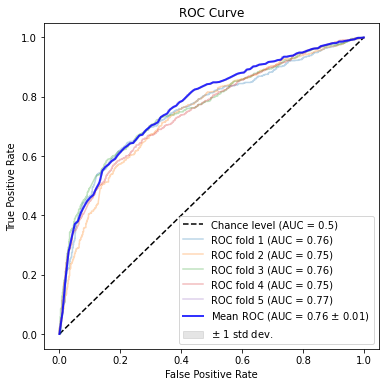

In [27]:
#Model training
#Parameters of training are changed in the method defenition
model = Model(inputs=input_, outputs=output_)
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-4), metrics = ['accuracy'])

tr_acc, tst_acc, f1_score, cm_mat = plot_keras_roc(5, taiwanMutivariateData, taiwanLabels, model)

Average train Acc: 0.68 
Average test Acc: 0.68 
Average f1-score 0.71


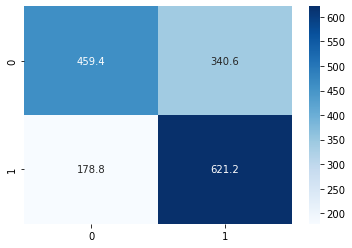

In [31]:
#Remaning metrics and confusion matrix
print(f'Average train Acc: {mean(tr_acc):.2f} \nAverage test Acc: {mean(tst_acc):.2f} \nAverage f1-score {mean(f1_score):.2f}')

sns.heatmap(sum(cm_mat)/5, annot=True, cmap='Blues', fmt='g')
plt.show()

## GCN

In [34]:
#Edges
taiWanedges_ = pd.read_csv('data/Taiwan/Taiwan_Distance_8000.csv', sep=';', index_col=0)

In [35]:
taiWanDist = np.zeros((8000, 8000))

print(f'Total rows to process {len(taiWanedges_)}')

for id_, row_ in taiWanedges_.iterrows():
    taiWanDist[int(row_[0]-1)][int(row_[1])-1] = row_[2]
    taiWanDist[int(row_[1]-1)][int(row_[0])-1] = row_[2]
    
    if id_ % 200000 == 0:
        print(id_)

8000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
123

In [36]:
scaler = StandardScaler()
scaledFeat = scaler.fit_transform(taiwanFeatures)

In [37]:
taiWanAdj = (taiWanDist < 0.07).astype(int)

In [38]:
taiwanAhat = taiWanAdj

A = GCNConv.preprocess(taiwanAhat).astype('f4')

In [48]:
#Input layers
X_in = Input(shape=(18))
adj_in = Input((8000, ), sparse=True)

# dropout_1 = Dropout(0.3)(X_in)
graph_conv_1 = GCNConv(16,
                         activation='relu',
#                          kernel_regularizer=regularizers.l2(5e-4),
                         use_bias=False)([X_in, adj_in])

# dropout_2 = Dropout(0.3)(graph_conv_1)
graph_conv_2 = GCNConv(16,
                         activation='relu',
#                          kernel_regularizer=regularizers.l2(5e-4),
                         use_bias=False)([graph_conv_1, adj_in])


# dropout_3 = Dropout(0.3)(graph_conv_2)
graph_conv_3 = GCNConv(1,
                         activation='sigmoid',
#                          kernel_regularizer=regularizers.l2(5e-4),
                         use_bias=False)([graph_conv_2, adj_in])

model = Model(inputs=[X_in, adj_in], outputs=graph_conv_3)

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 8000)]       0           []                               
                                                                                                  
 gcn_conv_3 (GCNConv)           (None, 16)           288         ['input_8[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 gcn_conv_4 (GCNConv)           (None, 16)           256         ['gcn_conv_3[0][0]',      

In [55]:
#Defining a train_mask
train_idx, test_idx = train_test_split(list(range(0, taiwanTSData.shape[0])), test_size=0.2)

train_mask = np.zeros((8000,), dtype='bool')
train_mask[train_idx] = 1

In [46]:
#Alternative to edge data, identity matrix
identity_matrix = np.identity(8000)

model = Model(inputs=[X_in, adj_in], outputs=graph_conv_3)

model.compile(optimizer=Adam(learning_rate=5e-4),
             loss=tf.keras.losses.binary_crossentropy,
             metrics=['acc'])

# One run with all feature using a train_mask (no validation set)
history = model.fit([scaledFeat, A], taiwanLabels, sample_weight=train_mask, batch_size=8000, epochs=100)
            
#Row to run with the plotting
# tr_acc, tst_acc, f1_score, cm_mat = plot_keras_roc(5, scaledFeat, taiwanLabels, model, taiWanIdn, graph_based = True)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0000e+00 - acc: 0.4985
Epoch 2/100
1/1 [==============================] - 0s 467ms/step - loss: 0.0000e+00 - acc: 0.5001
Epoch 3/100
1/1 [==============================] - 0s 455ms/step - loss: 0.0000e+00 - acc: 0.5001
Epoch 4/100
1/1 [==============================] - 0s 449ms/step - loss: 0.0000e+00 - acc: 0.4985
Epoch 5/100
1/1 [==============================] - 0s 429ms/step - loss: 0.0000e+00 - acc: 0.4999
Epoch 6/100
1/1 [==============================] - 0s 475ms/step - loss: 0.0000e+00 - acc: 0.4986
Epoch 7/100
1/1 [==============================] - 0s 444ms/step - loss: 0.0000e+00 - acc: 0.5002
Epoch 8/100
1/1 [==============================] - 0s 445ms/step - loss: 0.0000e+00 - acc: 0.4990
Epoch 9/100
1/1 [==============================] - 0s 443ms/step - loss: 0.0000e+00 - acc: 0.4995
Epoch 10/100
1/1 [==============================] - 0s 437ms/step - loss: 0.0000e+00 - acc: 0.4990
Epoch 11/100
1/1 [====

1/1 [==============================] - 0s 424ms/step - loss: 0.0000e+00 - acc: 0.4995
Epoch 84/100
1/1 [==============================] - 0s 465ms/step - loss: 0.0000e+00 - acc: 0.4990
Epoch 85/100
1/1 [==============================] - 0s 427ms/step - loss: 0.0000e+00 - acc: 0.4990
Epoch 86/100
1/1 [==============================] - 0s 443ms/step - loss: 0.0000e+00 - acc: 0.5000
Epoch 87/100
1/1 [==============================] - 0s 452ms/step - loss: 0.0000e+00 - acc: 0.4971
Epoch 88/100
1/1 [==============================] - 0s 427ms/step - loss: 0.0000e+00 - acc: 0.4999
Epoch 89/100
1/1 [==============================] - 0s 443ms/step - loss: 0.0000e+00 - acc: 0.4997
Epoch 90/100
1/1 [==============================] - 0s 431ms/step - loss: 0.0000e+00 - acc: 0.5001
Epoch 91/100
1/1 [==============================] - 0s 441ms/step - loss: 0.0000e+00 - acc: 0.5001
Epoch 92/100
1/1 [==============================] - 0s 433ms/step - loss: 0.0000e+00 - acc: 0.5001
Epoch 93/100
1/1 [=====

Average Acc: 0.68 
Average f1-score 0.71


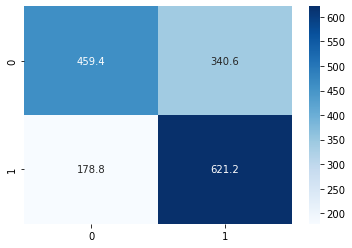

In [57]:
#Other metrics and confusion matrix
print(f'Average Acc: {mean(tr_acc):.2f} \nAverage f1-score {mean(f1_score):.2f}')

sns.heatmap(sum(cm_mat)/5, annot=True, cmap='Blues', fmt='g')
plt.show()

## LSTM-GCN

In [59]:
#Input layers
X_in = Input(shape=(6, 3))
adj_in = Input((8000, ), sparse=True)
# -------------------------
#LSTM layers
lstm_ = LSTM(100)(X_in)
# -----------------------
#GCN layers

# dropout_1 = Dropout(0.3)(lstm_)
graph_conv_1 = GCNConv(16,
                         activation='relu',
#                          kernel_regularizer=regularizers.l2(5e-4),
                         use_bias=False)([lstm_, adj_in])

# dropout_2 = Dropout(0.3)(graph_conv_1)
graph_conv_2 = GCNConv(16,
                         activation='relu',
#                          kernel_regularizer=regularizers.l2(5e-4),
                         use_bias=False)([graph_conv_1, adj_in])


# dropout_3 = Dropout(0.3)(graph_conv_2)
graph_conv_3 = GCNConv(1,
                         activation='sigmoid',
#                          kernel_regularizer=regularizers.l2(5e-4),
                         use_bias=False)([graph_conv_2, adj_in])

model = Model(inputs=[X_in, adj_in], outputs=graph_conv_3)

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 6, 3)]       0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (None, 100)          41600       ['input_12[0][0]']               
                                                                                                  
 input_13 (InputLayer)          [(None, 8000)]       0           []                               
                                                                                                  
 gcn_conv_9 (GCNConv)           (None, 16)           1600        ['lstm_4[0][0]',                 
                                                                  'input_13[0][0]']        

To run model first process the edges in the GCN part of the notebook or use the identity matrix below

In [65]:
#Alternative to edge data, identity matrix
identity_matrix = np.identity(8000)

model = Model(inputs=[X_in, adj_in], outputs=graph_conv_3)

model.compile(optimizer=Adam(learning_rate=5e-4),
             loss=tf.keras.losses.binary_crossentropy,
             metrics=['acc'])

# One run with all feature using a train_mask (no validation set)
history = model.fit([taiwanMutivariateData, A], taiwanLabels, sample_weight=train_mask, batch_size=8000, epochs=100)

#Plotting and cross valiation, set metric is function defenition
# tr_acc, tst_acc, f1_score, cm_mat = plot_keras_roc(5, taiwanMutivariateData, taiwanLabels, model, A, graph_based=True)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 0.5545 - acc: 0.5000
Epoch 2/100
1/1 [==============================] - 1s 648ms/step - loss: 0.5545 - acc: 0.5000
Epoch 3/100
1/1 [==============================] - 1s 613ms/step - loss: 0.5545 - acc: 0.5000
Epoch 4/100
1/1 [==============================] - 1s 604ms/step - loss: 0.5545 - acc: 0.5000
Epoch 5/100
1/1 [==============================] - 1s 622ms/step - loss: 0.5545 - acc: 0.5000
Epoch 6/100
1/1 [==============================] - 1s 609ms/step - loss: 0.5545 - acc: 0.5000
Epoch 7/100
1/1 [==============================] - 1s 626ms/step - loss: 0.5545 - acc: 0.5000
Epoch 8/100
1/1 [==============================] - 1s 664ms/step - loss: 0.5545 - acc: 0.5000
Epoch 9/100
1/1 [==============================] - 1s 656ms/step - loss: 0.5545 - acc: 0.5000
Epoch 10/100
1/1 [==============================] - 1s 641ms/step - loss: 0.5545 - acc: 0.5000
Epoch 11/100
1/1 [==============================] - 1s 650ms/s

1/1 [==============================] - 1s 627ms/step - loss: 0.5545 - acc: 0.5000
Epoch 88/100
1/1 [==============================] - 1s 636ms/step - loss: 0.5545 - acc: 0.5000
Epoch 89/100
1/1 [==============================] - 1s 634ms/step - loss: 0.5545 - acc: 0.5000
Epoch 90/100
1/1 [==============================] - 1s 631ms/step - loss: 0.5545 - acc: 0.5000
Epoch 91/100
1/1 [==============================] - 1s 693ms/step - loss: 0.5545 - acc: 0.5000
Epoch 92/100
1/1 [==============================] - 1s 735ms/step - loss: 0.5545 - acc: 0.5000
Epoch 93/100
1/1 [==============================] - 1s 655ms/step - loss: 0.5545 - acc: 0.5000
Epoch 94/100
1/1 [==============================] - 1s 709ms/step - loss: 0.5545 - acc: 0.5000
Epoch 95/100
1/1 [==============================] - 1s 651ms/step - loss: 0.5545 - acc: 0.5000
Epoch 96/100
1/1 [==============================] - 1s 646ms/step - loss: 0.5545 - acc: 0.5000
Epoch 97/100
1/1 [==============================] - 1s 682ms/st

Average Acc: 0.68 
Average f1-score 0.71


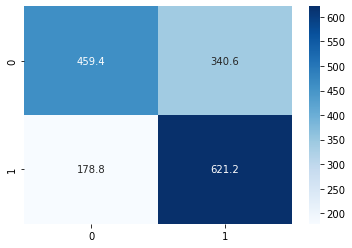

In [64]:
print(f'Average Acc: {mean(tr_acc):.2f} \nAverage f1-score {mean(f1_score):.2f}')

sns.heatmap(sum(cm_mat)/5, annot=True, cmap='Blues', fmt='g')
plt.show()